# The codes for inferring subsurface porosity from seismic trace data with uncertainty evaluation using ensemble deep learning

In [1]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import numpy as np
import pandas as pd
import pyvista as pv
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from keras.utils import normalize
from numpy import arange,absolute,mean,std

In [2]:
pv.set_jupyter_backend('static') 
pv.global_theme.background = 'white' 

ArgS = dict(height=0.6,vertical=True,position_x=0.85, position_y=0.20,title_font_size=26,label_font_size=20,shadow=False,
           n_labels=12,italic=False ,fmt="%.6f" ,font_family="times",color='k') 

ArgP = dict(height=0.6,vertical=True,position_x=0.85,position_y=0.20,title_font_size=26,label_font_size=20,shadow=False,
            n_labels=12,italic=False ,fmt="%.6f" ,font_family="times",color='k')

In [3]:
Seismic = np.loadtxt('SeismicTraces.dat', unpack = True)
print('The shape of testing data is:', Seismic.shape)

ReshapedDataSeis = Seismic.reshape((78,201,201))
mat_sliceSeis = ReshapedDataSeis[8:] # Simple indexing
TransposedDataSeis=mat_sliceSeis.T
FlippedDataSeis=np.flip(TransposedDataSeis)

print ('The shape of reshaped tata is:', mat_sliceSeis.shape)
print ('The shape of transposed and flippedData is:', FlippedDataSeis.shape)

The shape of testing data is: (78, 40401)
The shape of reshaped tata is: (70, 201, 201)
The shape of transposed and flippedData is: (201, 201, 70)


In [4]:
SeisData = Seismic.T
SeiSamples = pd.DataFrame(SeisData)
TestingData=SeiSamples.drop([0, 1], axis=1)
NormTestingData = normalize(TestingData, axis=1)

In [5]:
TestingData

,2,3,4,5,6,7,8,9,10,11,...,68,69,70,71,72,73,74,75,76,77
0,1656.0,8068.0,3195.0,-1685.0,1707.0,4408.0,1063.0,-1941.0,-2036.0,-2404.0,...,4473.0,3927.0,-2623.0,-2860.0,4449.0,6420.0,150.0,-2786.0,1416.0,2299.0
1,4471.0,9707.0,1790.0,-2814.0,2589.0,4529.0,-104.0,-2018.0,-1535.0,-3070.0,...,3938.0,3351.0,-2277.0,-1843.0,5376.0,5870.0,-2056.0,-4056.0,2116.0,2690.0
2,5381.0,9214.0,-690.0,-2437.0,4860.0,3947.0,-1625.0,-1260.0,-522.0,-3204.0,...,3744.0,3443.0,-1186.0,-668.0,5069.0,4665.0,-1918.0,-2564.0,2315.0,1504.0
3,6218.0,8487.0,-789.0,-998.0,4872.0,3272.0,-546.0,-969.0,-2179.0,-3380.0,...,1998.0,2207.0,282.0,1501.0,4272.0,1977.0,-2810.0,-1324.0,3351.0,1125.0
4,9936.0,7602.0,-1631.0,228.0,5254.0,2533.0,-1019.0,-1367.0,-2810.0,-4298.0,...,2187.0,1476.0,-426.0,1051.0,4155.0,2259.0,-2440.0,-1616.0,2087.0,325.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40396,-585.0,2731.0,2339.0,-4861.0,-3640.0,5345.0,4753.0,-2615.0,-2277.0,1491.0,...,109.0,883.0,-471.0,-1858.0,-1832.0,70.0,3523.0,4102.0,-612.0,-4306.0
40397,-917.0,4440.0,4416.0,-4828.0,-4994.0,4457.0,4578.0,-1814.0,-1072.0,936.0,...,-228.0,712.0,-207.0,-1075.0,-1651.0,-555.0,3771.0,4500.0,-2470.0,-6176.0
40398,-834.0,6179.0,4310.0,-6756.0,-5422.0,5164.0,4267.0,-1968.0,-327.0,843.0,...,-8.0,1220.0,78.0,-1297.0,-1896.0,-356.0,3952.0,3690.0,-3408.0,-5108.0
40399,221.0,4244.0,1505.0,-6901.0,-3344.0,6195.0,3707.0,-2493.0,-124.0,1383.0,...,1077.0,1537.0,-660.0,-1784.0,-1417.0,-14.0,3249.0,3073.0,-2546.0,-3849.0


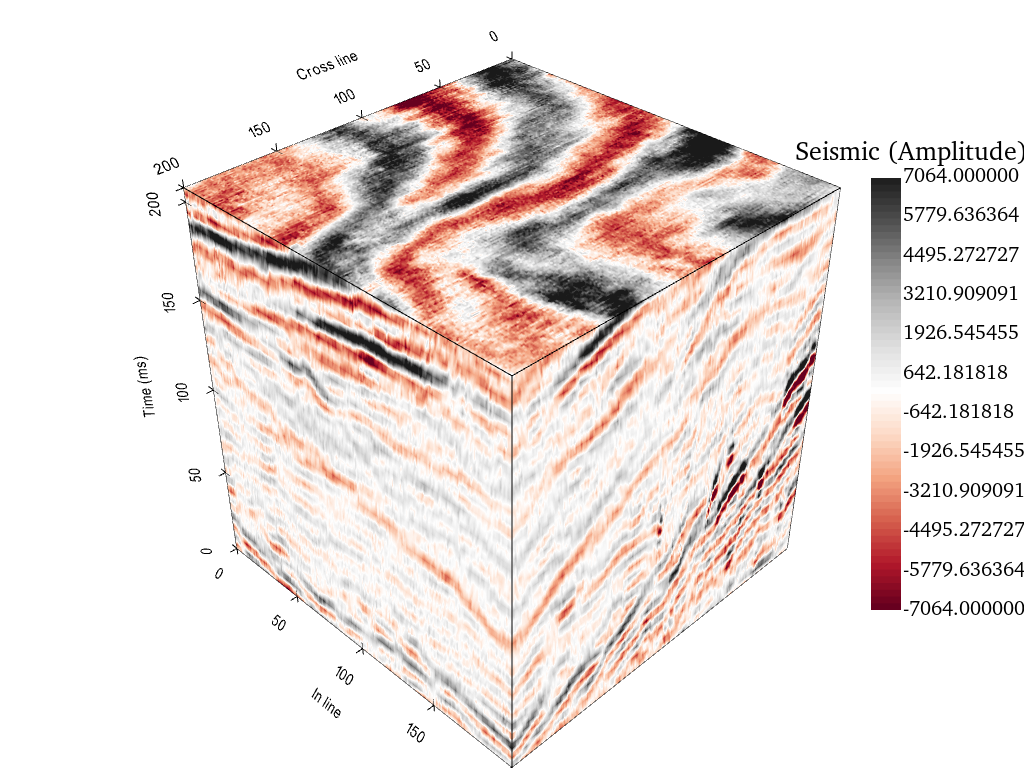

In [7]:
VolumeSeis = pv.UniformGrid()
VolumeSeis.dimensions = FlippedDataSeis.shape

VolumeSeis.origin = (0 , 0 , 0)
VolumeSeis.spacing = (1, 1, 3)  # These are the cell sizes along each axis
VolumeSeis.point_data["Seismic (Amplitude)"] = FlippedDataSeis.flatten(order='F').T

SeismicPlot = pv.Plotter()

SeismicPlot.add_mesh(VolumeSeis ,clim=[-7064,7064] ,flip_scalars=False ,cmap='RdGy' ,lighting=False ,
               scalar_bar_args=ArgP ,render_points_as_spheres=False ,render_lines_as_tubes=True ,
               use_transparency=False ,smooth_shading=True ,annotations=False ,pbr=True ,roughness=0.5 ,
               edge_color=None ,point_size=50.0 ,line_width=500 ,preference='cells')

SeismicPlot.show_grid(xlabel="Cross line", ylabel="In line", zlabel="Time (ms)",
                location='outer',all_edges=True ,padding=0.0  ,color='k' ,use_2d=40 ,grid='outer')

SeismicPlot.show()

In [8]:
NormTestingData

,2,3,4,5,6,7,8,9,10,11,...,68,69,70,71,72,73,74,75,76,77
0,0.091336,0.444987,0.176219,-0.092935,0.094149,0.243121,0.058629,-0.107055,-0.112295,-0.132591,...,0.246706,0.216592,-0.144670,-0.157742,0.245382,0.354092,0.008273,-0.153660,0.078099,0.126800
1,0.224336,0.487057,0.089815,-0.141195,0.129905,0.227247,-0.005218,-0.101255,-0.077020,-0.154040,...,0.197593,0.168139,-0.114250,-0.092474,0.269746,0.294532,-0.103162,-0.203513,0.106172,0.134973
2,0.282216,0.483245,-0.036188,-0.127813,0.254891,0.207008,-0.085226,-0.066083,-0.027377,-0.168040,...,0.196361,0.180574,-0.062202,-0.035034,0.265853,0.244664,-0.100593,-0.134474,0.121414,0.078880
3,0.367624,0.501773,-0.046648,-0.059004,0.288045,0.193449,-0.032281,-0.057290,-0.128828,-0.199834,...,0.118127,0.130483,0.016673,0.088743,0.252572,0.116885,-0.166134,-0.078278,0.198120,0.066513
4,0.542535,0.415092,-0.089057,0.012449,0.286884,0.138309,-0.055640,-0.074642,-0.153434,-0.234684,...,0.119417,0.080594,-0.023261,0.057388,0.226875,0.123348,-0.133231,-0.088238,0.113956,0.017746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40396,-0.034640,0.161713,0.138501,-0.287838,-0.215538,0.316498,0.281443,-0.154844,-0.134830,0.088288,...,0.006454,0.052286,-0.027890,-0.110019,-0.108480,0.004145,0.208610,0.242895,-0.036239,-0.254975
40397,-0.047539,0.230180,0.228936,-0.250295,-0.258900,0.231061,0.237334,-0.094042,-0.055575,0.048524,...,-0.011820,0.036912,-0.010731,-0.055730,-0.085592,-0.028772,0.195497,0.233290,-0.128050,-0.320178
40398,-0.041370,0.306507,0.213796,-0.335129,-0.268956,0.256158,0.211663,-0.097622,-0.016221,0.041817,...,-0.000397,0.060518,0.003869,-0.064337,-0.094050,-0.017659,0.196037,0.183041,-0.169053,-0.253380
40399,0.012532,0.240666,0.085345,-0.391337,-0.189629,0.351302,0.210214,-0.141371,-0.007032,0.078426,...,0.061074,0.087159,-0.037427,-0.101166,-0.080354,-0.000794,0.184242,0.174262,-0.144377,-0.218267


In [20]:
from keras.models import load_model

model1 = load_model('PorosityPredictionModel1.h5')
model1.summary()
Exp1=model1.predict(NormTestingData)
print('Predicted: %s' % Exp1)

model2 = load_model('PorosityPredictionModel2.h5')
model2.summary()
Exp2=model2.predict(NormTestingData)
print('Predicted: %s' % Exp2)

model3 = load_model('PorosityPredictionModel3.h5')
model3.summary()
Exp3=model3.predict(NormTestingData)
print('Predicted: %s' % Exp3)

model4 = load_model('PorosityPredictionModel4.h5')
model4.summary()
Exp4=model4.predict(NormTestingData)
print('Predicted: %s' % Exp4)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400)               30800     
                                                                 
 dense_1 (Dense)             (None, 400)               160400    
                                                                 
 dense_2 (Dense)             (None, 400)               160400    
                                                                 
 dense_3 (Dense)             (None, 400)               160400    
                                                                 
 dense_4 (Dense)             (None, 76)                30476     
                                                                 
Total params: 542,476
Trainable params: 542,476
Non-trainable params: 0
_________________________________________________________________
1263/1263 [==============================] - 3s 2m

In [21]:
PredPorosityExp1=pd.DataFrame(Exp1).T
PredPorosityVExp1=PredPorosityExp1
PredPorosityVExp1['SD']=std(PredPorosityExp1, axis=1)
PredPorosityVExp1['MeanPred']=mean(PredPorosityExp1, axis=1)
print(PredPorosityVExp1.shape)

PredPorosityExp2=pd.DataFrame(Exp2).T
PredPorosityVExp2=PredPorosityExp2
PredPorosityVExp2['SD']=std(PredPorosityExp2, axis=1)
PredPorosityVExp2['MeanPred']=mean(PredPorosityExp2, axis=1)
print(PredPorosityVExp2.shape)

PredPorosityExp3=pd.DataFrame(Exp3).T
PredPorosityVExp3=PredPorosityExp3
PredPorosityVExp3['SD']=std(PredPorosityExp3, axis=1)
PredPorosityVExp3['MeanPred']=mean(PredPorosityExp3, axis=1)
print(PredPorosityVExp3.shape)

PredPorosityExp4=pd.DataFrame(Exp4).T
PredPorosityVExp4=PredPorosityExp4
PredPorosityVExp4['SD']=std(PredPorosityExp4, axis=1)
PredPorosityVExp4['MeanPred']=mean(PredPorosityExp4, axis=1)
print(PredPorosityVExp4.shape)

(76, 40403)
(76, 40403)
(76, 40403)
(76, 40403)


In [22]:
PredPorosityVExp1

,0,1,2,3,4,5,6,7,8,9,...,40393,40394,40395,40396,40397,40398,40399,40400,SD,MeanPred
0,0.294595,0.293736,0.292646,0.291613,0.292667,0.296264,0.300952,0.303662,0.304408,0.308335,...,0.327562,0.326334,0.329053,0.328438,0.328764,0.327168,0.327941,0.325424,0.015061,0.327503
1,0.308952,0.311258,0.310351,0.312738,0.316055,0.320017,0.323160,0.325348,0.326021,0.327875,...,0.329539,0.329034,0.331953,0.330823,0.333464,0.331886,0.330862,0.328997,0.014642,0.327041
2,0.328865,0.331191,0.329574,0.332478,0.333494,0.336160,0.336467,0.336475,0.337270,0.336427,...,0.328834,0.329700,0.330744,0.329019,0.331125,0.330629,0.329023,0.328335,0.013352,0.325821
3,0.340429,0.340209,0.338775,0.340773,0.340346,0.341840,0.340403,0.339942,0.341759,0.340595,...,0.326029,0.326930,0.326947,0.325634,0.326674,0.326875,0.324121,0.324886,0.011954,0.323544
4,0.342389,0.341317,0.340538,0.341997,0.342490,0.342806,0.341198,0.342851,0.345489,0.345027,...,0.321404,0.321367,0.321588,0.320583,0.321600,0.321157,0.319369,0.319630,0.011254,0.322295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.307804,0.311242,0.312650,0.315322,0.313768,0.314691,0.313093,0.311839,0.311080,0.310921,...,0.281930,0.280943,0.280369,0.282151,0.282222,0.282326,0.282116,0.281752,0.015523,0.296481
72,0.316029,0.316604,0.315864,0.315395,0.313478,0.312060,0.310252,0.306839,0.306415,0.304012,...,0.286484,0.285818,0.286566,0.287664,0.286898,0.286602,0.286955,0.285923,0.015493,0.293341
73,0.313056,0.311985,0.311187,0.309509,0.308691,0.306066,0.304669,0.301912,0.302159,0.300711,...,0.293712,0.292872,0.293774,0.292817,0.290834,0.290689,0.291343,0.290795,0.014724,0.290673
74,0.305498,0.304874,0.304980,0.302826,0.303012,0.301360,0.300303,0.300001,0.301560,0.300978,...,0.297074,0.296106,0.295287,0.292909,0.290432,0.290470,0.290900,0.290776,0.013695,0.288454


In [23]:
PredPorosityVExp2

,0,1,2,3,4,5,6,7,8,9,...,40393,40394,40395,40396,40397,40398,40399,40400,SD,MeanPred
0,0.292181,0.291715,0.290657,0.289804,0.290196,0.294733,0.299483,0.303115,0.306485,0.309003,...,0.327376,0.326540,0.326433,0.325704,0.325554,0.325845,0.325137,0.324553,0.015082,0.326336
1,0.307456,0.308088,0.308998,0.310736,0.311509,0.317783,0.321118,0.324209,0.327892,0.330081,...,0.328731,0.328794,0.328966,0.328903,0.327894,0.327878,0.327767,0.327347,0.014625,0.325674
2,0.325598,0.326812,0.327835,0.329713,0.329922,0.333465,0.334134,0.334454,0.336461,0.337400,...,0.329508,0.329712,0.330070,0.329533,0.328474,0.327944,0.328388,0.327751,0.013423,0.323979
3,0.335367,0.336531,0.336541,0.337152,0.337083,0.337252,0.335599,0.335721,0.337663,0.337655,...,0.324973,0.324075,0.325185,0.323775,0.323774,0.323437,0.323289,0.322115,0.012012,0.321421
4,0.337554,0.338035,0.338304,0.339420,0.340271,0.340121,0.338536,0.340173,0.341448,0.341846,...,0.319221,0.318555,0.319513,0.318561,0.319034,0.319023,0.318149,0.317125,0.010994,0.321501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.310941,0.311211,0.313093,0.313638,0.313649,0.316567,0.315885,0.316422,0.314727,0.313392,...,0.280935,0.281513,0.281051,0.281608,0.282398,0.282474,0.282035,0.281022,0.015532,0.296193
72,0.318597,0.318569,0.318759,0.315977,0.315178,0.314810,0.313064,0.311185,0.308476,0.306588,...,0.286481,0.288632,0.287524,0.288115,0.287273,0.286811,0.287195,0.285923,0.015483,0.293994
73,0.314909,0.314808,0.314592,0.311107,0.310243,0.307355,0.305394,0.304904,0.304961,0.304288,...,0.294047,0.295710,0.294669,0.294318,0.292401,0.292190,0.292398,0.290680,0.014679,0.291821
74,0.305864,0.305929,0.306592,0.305733,0.305694,0.303132,0.301605,0.303069,0.303481,0.303929,...,0.296551,0.297443,0.296467,0.294875,0.292062,0.291718,0.292121,0.290950,0.013608,0.289354


In [24]:
PredPorosityVExp3

,0,1,2,3,4,5,6,7,8,9,...,40393,40394,40395,40396,40397,40398,40399,40400,SD,MeanPred
0,0.292884,0.293868,0.292729,0.292796,0.294994,0.299028,0.303305,0.307405,0.308045,0.309236,...,0.329311,0.328358,0.328908,0.328726,0.328884,0.329799,0.328786,0.326403,0.015108,0.329294
1,0.310784,0.314429,0.313493,0.316608,0.319507,0.322690,0.325141,0.328875,0.328279,0.328570,...,0.331835,0.331443,0.331581,0.331990,0.332817,0.333161,0.332864,0.330192,0.014776,0.328142
2,0.330004,0.333751,0.331880,0.335284,0.335185,0.337883,0.340206,0.340390,0.339484,0.339141,...,0.332190,0.332235,0.331034,0.330139,0.331339,0.332161,0.329720,0.328593,0.013648,0.325392
3,0.336172,0.338940,0.338097,0.340896,0.338816,0.340654,0.341653,0.340797,0.341936,0.341436,...,0.328089,0.327162,0.326439,0.324772,0.326809,0.326679,0.323689,0.324750,0.012131,0.322773
4,0.338797,0.339698,0.338840,0.339557,0.340018,0.339526,0.341630,0.342564,0.344658,0.344801,...,0.321125,0.318835,0.320573,0.319745,0.320965,0.320397,0.318002,0.320528,0.011059,0.320532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.309817,0.311620,0.315241,0.314942,0.315565,0.317221,0.321191,0.316877,0.316037,0.315006,...,0.280791,0.279903,0.280185,0.281054,0.281880,0.281419,0.281030,0.280854,0.015667,0.296365
72,0.319339,0.318742,0.319958,0.317410,0.315777,0.314964,0.314681,0.310060,0.310217,0.307517,...,0.286767,0.287002,0.287591,0.288308,0.287019,0.286211,0.286230,0.286366,0.015737,0.294142
73,0.316253,0.314430,0.314598,0.312313,0.311082,0.308150,0.308643,0.305218,0.305880,0.304797,...,0.295471,0.294713,0.295290,0.295245,0.292767,0.292057,0.292178,0.292208,0.014987,0.292181
74,0.306796,0.305772,0.305552,0.304551,0.304416,0.302880,0.303716,0.302648,0.305031,0.304148,...,0.298000,0.297702,0.298202,0.295990,0.292064,0.291582,0.291358,0.291582,0.013949,0.289077


In [25]:
PredPorosityVExp4

,0,1,2,3,4,5,6,7,8,9,...,40393,40394,40395,40396,40397,40398,40399,40400,SD,MeanPred
0,0.296235,0.295037,0.294008,0.290868,0.292731,0.296167,0.300513,0.304182,0.305924,0.306739,...,0.328758,0.326753,0.327465,0.327443,0.325694,0.326291,0.327533,0.325750,0.014936,0.327915
1,0.309531,0.311580,0.312192,0.313395,0.318585,0.323107,0.323959,0.327931,0.328277,0.326934,...,0.330779,0.327694,0.329281,0.329525,0.329635,0.328855,0.329504,0.328271,0.014534,0.326716
2,0.329676,0.331365,0.330683,0.333397,0.336271,0.338610,0.335372,0.336648,0.337999,0.337117,...,0.328662,0.327512,0.328476,0.327047,0.328209,0.329259,0.327502,0.326974,0.013373,0.324440
3,0.340489,0.339879,0.336598,0.339843,0.340663,0.341374,0.339138,0.338935,0.340108,0.340397,...,0.325365,0.324839,0.324685,0.323292,0.324236,0.325115,0.322548,0.323479,0.011893,0.322316
4,0.341658,0.339761,0.337131,0.341126,0.340723,0.339910,0.339266,0.340361,0.345110,0.342641,...,0.320846,0.320317,0.320648,0.319476,0.318558,0.319406,0.317553,0.319379,0.011007,0.320844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.306710,0.310320,0.311382,0.310844,0.313137,0.315822,0.317654,0.315144,0.312110,0.312510,...,0.276638,0.276189,0.276363,0.278295,0.277544,0.279889,0.280568,0.276987,0.015658,0.294934
72,0.318354,0.317589,0.316372,0.314271,0.313692,0.313239,0.314417,0.309098,0.307607,0.305744,...,0.283806,0.284299,0.283525,0.285770,0.282632,0.284452,0.286218,0.283466,0.015636,0.293071
73,0.314554,0.312691,0.311982,0.309889,0.307188,0.305872,0.306158,0.302811,0.304054,0.302684,...,0.291515,0.292024,0.291201,0.292875,0.287845,0.289182,0.290792,0.288755,0.014871,0.290508
74,0.305187,0.303976,0.305263,0.304044,0.301842,0.301584,0.301065,0.300443,0.303949,0.302791,...,0.294850,0.294057,0.294034,0.294175,0.288695,0.289913,0.289878,0.289004,0.013874,0.288116


In [26]:
PredictedF3PredPor=Exp1.T

F3Prediction = PredictedF3PredPor.reshape((76,201,201))
mat_sliceF3Por = F3Prediction[6:] # Simple indexing
TransposedDataF3Por=mat_sliceF3Por.T
FlippedDataF3Por=np.flip(TransposedDataF3Por)

VolumeF3Por = pv.UniformGrid()
VolumeF3Por.dimensions = FlippedDataF3Por.shape

VolumeF3Por.origin = (0 , 0 , 0)
VolumeF3Por.spacing = (1, 1, 3)  # These are the cell sizes along each axis
VolumeF3Por.point_data["Porosity (Fraction)"] = FlippedDataF3Por.flatten(order='F').T #'C', 'F', 'A', or 'K'

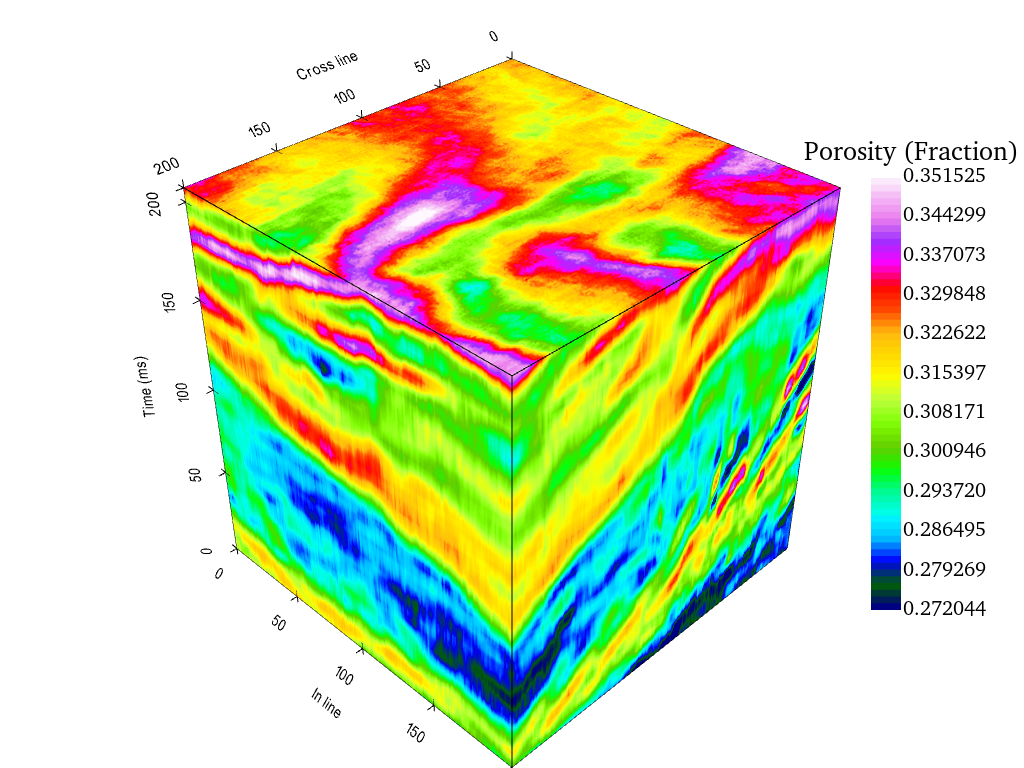

In [27]:
PorosityPlot = pv.Plotter()

PorosityPlot.add_mesh(VolumeF3Por ,clim=[0.2720436,0.3515245] ,flip_scalars=False ,cmap='gist_ncar' ,lighting=False ,
                      scalar_bar_args=ArgP ,render_points_as_spheres=False ,render_lines_as_tubes=True ,
                      use_transparency=False ,smooth_shading=True ,annotations=False ,pbr=True ,roughness=0.5 ,
                      edge_color=None ,point_size=50.0 ,line_width=500 ,preference='cells')

PorosityPlot.show_grid(xlabel="Cross line", ylabel="In line", zlabel="Time (ms)",
                       location='outer',all_edges=True ,padding=0.0  ,color='k' ,use_2d=40 ,grid='outer')
PorosityPlot.show()